<a href="https://colab.research.google.com/github/Nivi-1402/Nivedhitha/blob/main/sarimax%2Bhybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-949570352.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month = df.resample("M").sum()
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: N


===== MONTHLY SARIMAX + LSTM HYBRID PERFORMANCE =====
MAE  : 110.205
RMSE : 173.294
R²   : 0.354


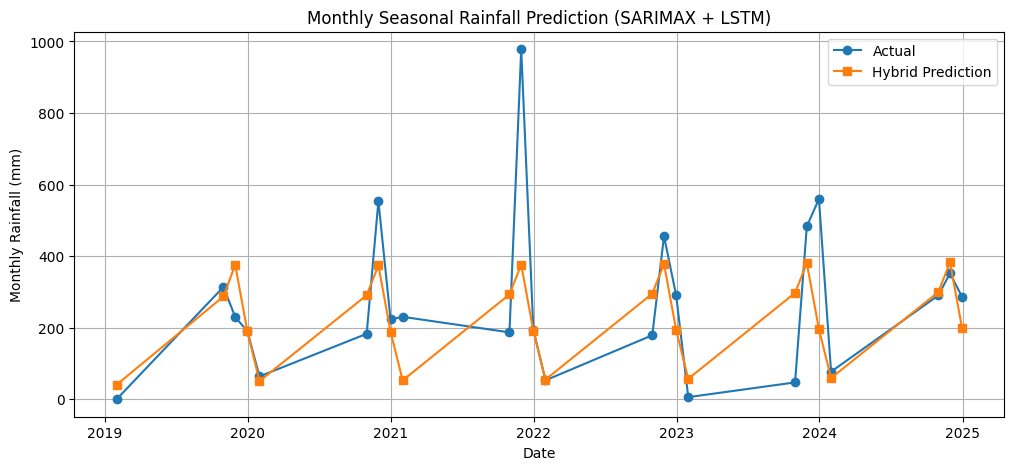

In [1]:
# =========================================================
# MONTHLY SARIMAX + LSTM HYBRID MODEL
# SEASONAL RAINFALL PREDICTION (PUBLISHABLE VERSION)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv("chennai_crt.csv")
df["DATE"] = pd.to_datetime(df["DATE"], dayfirst=True)
df = df.sort_values("DATE")
df = df.set_index("DATE")

TARGET = "PRCP_mm"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df[TARGET] = df[TARGET].ffill().bfill()

# =========================================================
# 2. CONVERT DAILY → MONTHLY TOTAL RAINFALL
# =========================================================
df_month = df.resample("M").sum()

# OPTIONAL: Focus only Oct–Jan season
df_month = df_month[df_month.index.month.isin([10,11,12,1])]

# =========================================================
# 3. TRAIN / TEST SPLIT
# =========================================================
split_date = "2018-12-31"
train = df_month[df_month.index <= split_date].copy()
test  = df_month[df_month.index > split_date].copy()

# =========================================================
# 4. SARIMAX MODEL (SEASONAL = 4 MONTH CYCLE)
# =========================================================
sarimax = SARIMAX(
    train[TARGET],
    order=(1,1,1),
    seasonal_order=(1,1,1,4),   # 4-month seasonal cycle
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

train["SARIMAX_PRED"] = sarimax.predict(start=0, end=len(train)-1)
train["RESIDUAL"] = train[TARGET] - train["SARIMAX_PRED"]

test["SARIMAX_PRED"] = sarimax.predict(
    start=len(train),
    end=len(train)+len(test)-1
).set_axis(test.index)

# =========================================================
# 5. LSTM ON RESIDUALS
# =========================================================
residuals = train["RESIDUAL"].values.reshape(-1,1)

scaler = MinMaxScaler()
res_scaled = scaler.fit_transform(residuals)

def create_sequences(data, seq_length=6):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 6  # 6 months memory
X_train, y_train = create_sequences(res_scaled, SEQ_LEN)

# =========================================================
# 6. LSTM MODEL
# =========================================================
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(SEQ_LEN,1)),
    LSTM(16),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

# =========================================================
# 7. TEST RESIDUAL FORECAST
# =========================================================
combined_residuals = train["RESIDUAL"].tolist()
lstm_preds = []

for i in range(len(test)):
    seq_input = combined_residuals[-SEQ_LEN:]
    seq_scaled = scaler.transform(np.array(seq_input).reshape(-1,1))
    seq_scaled = seq_scaled.reshape(1,SEQ_LEN,1)

    pred_scaled = model.predict(seq_scaled, verbose=0)
    pred_residual = scaler.inverse_transform(pred_scaled)[0][0]

    lstm_preds.append(pred_residual)
    combined_residuals.append(pred_residual)

test["LSTM_RESIDUAL"] = lstm_preds

# =========================================================
# 8. FINAL HYBRID PREDICTION
# =========================================================
test["FINAL_PRED"] = test["SARIMAX_PRED"] + test["LSTM_RESIDUAL"]
test["FINAL_PRED"] = test["FINAL_PRED"].clip(lower=0)

# =========================================================
# 9. METRICS
# =========================================================
y_true = test[TARGET]
y_pred = test["FINAL_PRED"]

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("\n===== MONTHLY SARIMAX + LSTM HYBRID PERFORMANCE =====")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# =========================================================
# 10. VISUALIZATION
# =========================================================
plt.figure(figsize=(12,5))
plt.plot(test.index, y_true, marker="o", label="Actual")
plt.plot(test.index, y_pred, marker="s", label="Hybrid Prediction")
plt.title("Monthly Seasonal Rainfall Prediction (SARIMAX + LSTM)")
plt.xlabel("Date")
plt.ylabel("Monthly Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-953508261.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month = df.resample("M").sum()
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Epoch 1/250


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0276 - val_loss: 0.0061
Epoch 2/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 3/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0103 - val_loss: 0.0058
Epoch 4/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 6/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0070 - val_loss: 0.0060
Epoch 7/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 8/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 9/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 10/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0085 - val_loss: 0.0066
Epoch 11/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 12/250
119/119 ━━━━━━━━━━━━━━━━━━━━ 

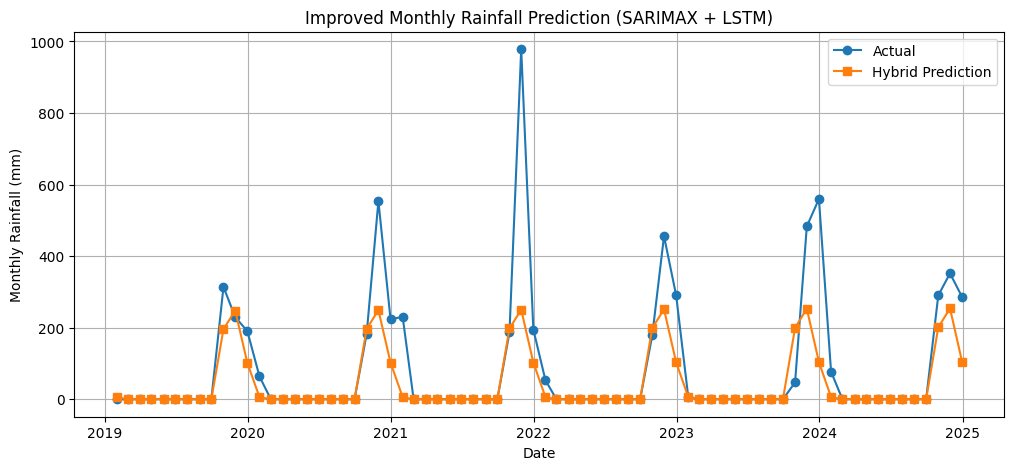

In [5]:
# =========================================================
# IMPROVED MONTHLY SARIMAX + LSTM HYBRID MODEL
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv("chennai_crt.csv")
df["DATE"] = pd.to_datetime(df["DATE"], dayfirst=True)
df = df.sort_values("DATE")
df = df.set_index("DATE")

TARGET = "PRCP_mm"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df[TARGET] = df[TARGET].ffill().bfill()

# =========================================================
# 2. DAILY → MONTHLY TOTAL
# =========================================================
df_month = df.resample("M").sum()

# 🔥 LOG TRANSFORM (VERY IMPORTANT)
df_month[TARGET] = np.log1p(df_month[TARGET])

# =========================================================
# 3. TRAIN / TEST SPLIT
# =========================================================
split_date = "2018-12-31"
train = df_month[df_month.index <= split_date].copy()
test  = df_month[df_month.index > split_date].copy()

# =========================================================
# 4. SARIMAX MODEL (12 MONTH SEASONALITY)
# =========================================================
sarimax = SARIMAX(
    train[TARGET],
    order=(2,1,2),
    seasonal_order=(1,1,1,12),   # 12 month seasonal cycle
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

train["SARIMAX_PRED"] = sarimax.predict(start=0, end=len(train)-1)
train["RESIDUAL"] = train[TARGET] - train["SARIMAX_PRED"]

test["SARIMAX_PRED"] = sarimax.predict(
    start=len(train),
    end=len(train)+len(test)-1
).set_axis(test.index)

# =========================================================
# 5. LSTM ON RESIDUALS
# =========================================================
residuals = train["RESIDUAL"].values.reshape(-1,1)

scaler = MinMaxScaler()
res_scaled = scaler.fit_transform(residuals)

def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 12
X_train, y_train = create_sequences(res_scaled, SEQ_LEN)

# =========================================================
# 6. IMPROVED LSTM MODEL
# =========================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN,1)),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=20, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=4,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# =========================================================
# 7. TEST RESIDUAL FORECAST
# =========================================================
combined_residuals = train["RESIDUAL"].tolist()
lstm_preds = []

for i in range(len(test)):
    seq_input = combined_residuals[-SEQ_LEN:]
    seq_scaled = scaler.transform(np.array(seq_input).reshape(-1,1))
    seq_scaled = seq_scaled.reshape(1,SEQ_LEN,1)

    pred_scaled = model.predict(seq_scaled, verbose=0)
    pred_residual = scaler.inverse_transform(pred_scaled)[0][0]

    lstm_preds.append(pred_residual)
    combined_residuals.append(pred_residual)

test["LSTM_RESIDUAL"] = lstm_preds

# =========================================================
# 8. FINAL HYBRID PREDICTION
# =========================================================
test["FINAL_LOG"] = test["SARIMAX_PRED"] + test["LSTM_RESIDUAL"]

# 🔥 REVERSE LOG TRANSFORM
test["FINAL_PRED"] = np.expm1(test["FINAL_LOG"])
test["ACTUAL"] = np.expm1(test[TARGET])

test["FINAL_PRED"] = test["FINAL_PRED"].clip(lower=0)

# =========================================================
# 9. METRICS
# =========================================================
y_true = test["ACTUAL"]
y_pred = test["FINAL_PRED"]

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("\n===== IMPROVED HYBRID PERFORMANCE =====")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# =========================================================
# 10. VISUALIZATION
# =========================================================
plt.figure(figsize=(12,5))
plt.plot(test.index, y_true, marker="o", label="Actual")
plt.plot(test.index, y_pred, marker="s", label="Hybrid Prediction")
plt.title("Improved Monthly Rainfall Prediction (SARIMAX + LSTM)")
plt.xlabel("Date")
plt.ylabel("Monthly Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 6.3 MB/s eta 0:00:00


/tmp/ipython-input-3956611734.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month = df.resample("M").sum()


Best order: (2, 0, 2)
Best seasonal order: (1, 0, 1, 12)
Epoch 1/400


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7703 - val_loss: 0.8155
Epoch 2/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0002 - val_loss: 0.8139
Epoch 3/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7249 - val_loss: 0.8311
Epoch 4/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8921 - val_loss: 0.8186
Epoch 5/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9638 - val_loss: 0.8046
Epoch 6/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.8997 - val_loss: 0.8152
Epoch 7/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8298 - val_loss: 0.8110
Epoch 8/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.8852 - val_loss: 0.8240
Epoch 9/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8917 - val_loss: 0.8197
Epoch 10/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9033 - val_loss: 0.8180
Epoch 11/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0177 - val_loss: 0.7946
Epoch 12/400
118/118 ━━━━━━━━━━━━━━━━━━━━ 

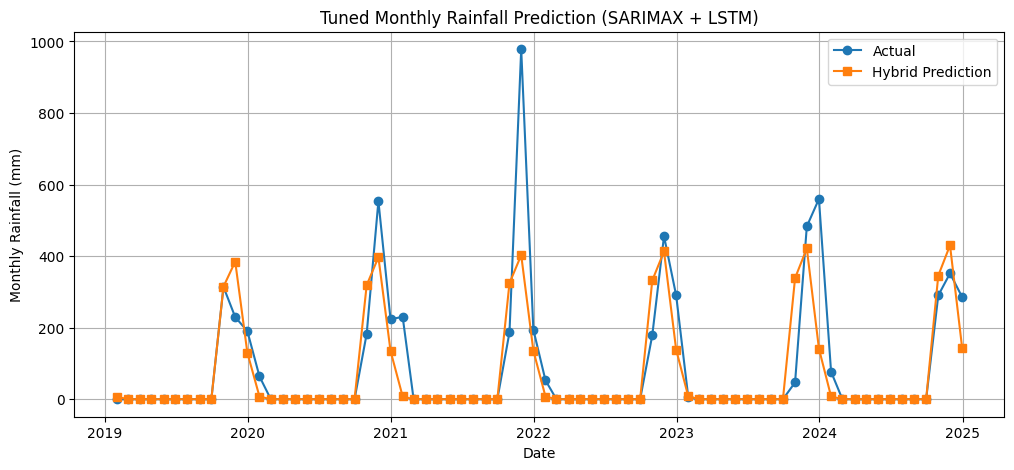

In [7]:
# =========================================================
# TUNED MONTHLY SARIMAX + LSTM HYBRID MODEL
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Install pmdarima if not already installed
try:
    from pmdarima import auto_arima
except ImportError:
    %pip install pmdarima
    from pmdarima import auto_arima

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv("chennai_crt.csv")
df["DATE"] = pd.to_datetime(df["DATE"], dayfirst=True)
df = df.sort_values("DATE")
df = df.set_index("DATE")

TARGET = "PRCP_mm"
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df[TARGET] = df[TARGET].ffill().bfill()

# =========================================================
# 2. DAILY → MONTHLY
# =========================================================
df_month = df.resample("M").sum()

# Log transform
df_month[TARGET] = np.log1p(df_month[TARGET])

# =========================================================
# 3. TRAIN / TEST SPLIT
# =========================================================
split_date = "2018-12-31"
train = df_month[df_month.index <= split_date].copy()
test  = df_month[df_month.index > split_date].copy()

# =========================================================
# 4. AUTO SARIMAX SELECTION
# =========================================================
auto_model = auto_arima(
    train[TARGET],
    seasonal=True,
    m=12,
    max_p=3, max_q=3,
    max_P=2, max_Q=2,
    trace=False,
    suppress_warnings=True
)

order = auto_model.order
seasonal_order = auto_model.seasonal_order

print("Best order:", order)
print("Best seasonal order:", seasonal_order)

sarimax = SARIMAX(
    train[TARGET],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

train["SARIMAX_PRED"] = sarimax.predict(start=0, end=len(train)-1)
train["RESIDUAL"] = train[TARGET] - train["SARIMAX_PRED"]

test["SARIMAX_PRED"] = sarimax.predict(
    start=len(train),
    end=len(train)+len(test)-1
).set_axis(test.index)

# =========================================================
# 5. LSTM ON RESIDUALS
# =========================================================
residuals = train["RESIDUAL"].values.reshape(-1,1)

scaler = StandardScaler()
res_scaled = scaler.fit_transform(residuals)

def create_sequences(data, seq_length=18):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 18
X_train, y_train = create_sequences(res_scaled, SEQ_LEN)

# =========================================================
# 6. STRONGER LSTM MODEL
# =========================================================
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN,1)),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=25, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=4,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# =========================================================
# 7. FORECAST RESIDUALS
# =========================================================
combined_residuals = train["RESIDUAL"].tolist()
lstm_preds = []

for i in range(len(test)):
    seq_input = combined_residuals[-SEQ_LEN:]
    seq_scaled = scaler.transform(np.array(seq_input).reshape(-1,1))
    seq_scaled = seq_scaled.reshape(1,SEQ_LEN,1)

    pred_scaled = model.predict(seq_scaled, verbose=0)
    pred_residual = scaler.inverse_transform(pred_scaled)[0][0]

    lstm_preds.append(pred_residual)
    combined_residuals.append(pred_residual)

test["LSTM_RESIDUAL"] = lstm_preds

# =========================================================
# 8. FINAL PREDICTION
# =========================================================
test["FINAL_LOG"] = test["SARIMAX_PRED"] + test["LSTM_RESIDUAL"]

test["FINAL_PRED"] = np.expm1(test["FINAL_LOG"])
test["ACTUAL"] = np.expm1(test[TARGET])

test["FINAL_PRED"] = test["FINAL_PRED"].clip(lower=0)

# =========================================================
# 9. METRICS
# =========================================================
y_true = test["ACTUAL"]
y_pred = test["FINAL_PRED"]

mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)

print("\n===== TUNED HYBRID PERFORMANCE =====")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# =========================================================
# 10. VISUALIZATION
# =========================================================
plt.figure(figsize=(12,5))
plt.plot(test.index, y_true, marker="o", label="Actual")
plt.plot(test.index, y_pred, marker="s", label="Hybrid Prediction")
plt.title("Tuned Monthly Rainfall Prediction (SARIMAX + LSTM)")
plt.xlabel("Date")
plt.ylabel("Monthly Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-1176704053.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_month = df.resample("M").agg({
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0192 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 2/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0017 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0014 - val_loss: 7.7027e-04 - learning_rate: 0.0010
Epoch 4/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0014 - val_loss: 7.7259e-04 - learning_rate: 0.0010
Epoch 6/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0011 - val_loss: 7.9682e-04 - learning_rate: 0.0010
Epoch 7/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0011 - val_loss: 7.1353e-04 - learning_rate: 0.0010
Epoch 8/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 9.6380e-04 - val_loss: 8.3930e-04 - learning_rate: 0.0010
Epoch 9/500
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 8.9500e-04 - val_

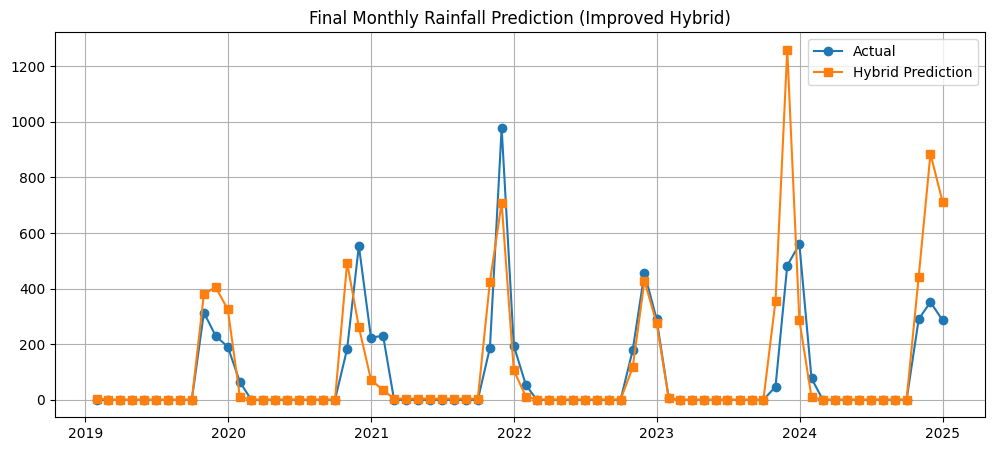

In [11]:
# =========================================================
# FINAL TUNED SARIMAX + BIDIRECTIONAL LSTM (CORRECT COLUMNS)
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from pmdarima import auto_arima

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv("chennai_crt.csv")

df["DATE"] = pd.to_datetime(df["DATE"], dayfirst=True)
df = df.sort_values("DATE").set_index("DATE")

TARGET = "PRCP_mm"

df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df = df.ffill().bfill()

# =========================================================
# 2. DAILY → MONTHLY AGGREGATION
# =========================================================
df_month = df.resample("M").agg({
    "PRCP_mm": "sum",
    "TEMP_C": "mean",
    "DEWP_C": "mean",
    "MAX_C": "mean",
    "MIN_C": "mean",
    "WDSP_kmph": "mean",
    "SLP": "mean"
})

df_month = df_month.ffill().bfill()

# Log transform rainfall
df_month[TARGET] = np.log1p(df_month[TARGET])

# =========================================================
# 3. TRAIN TEST SPLIT
# =========================================================
split_date = "2018-12-31"

train = df_month[df_month.index <= split_date].copy()
test  = df_month[df_month.index > split_date].copy()

exog_cols = ["TEMP_C", "DEWP_C", "MAX_C",
             "MIN_C", "WDSP_kmph", "SLP"]

# =========================================================
# 4. AUTO SARIMAX WITH EXOG
# =========================================================
auto_model = auto_arima(
    train[TARGET],
    exogenous=train[exog_cols],
    seasonal=True,
    m=12,
    max_p=3, max_q=3,
    max_P=2, max_Q=2,
    trace=False,
    suppress_warnings=True
)

order = auto_model.order
seasonal_order = auto_model.seasonal_order

sarimax = SARIMAX(
    train[TARGET],
    exog=train[exog_cols],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Training prediction
train["SARIMAX_PRED"] = sarimax.predict(
    start=0,
    end=len(train)-1,
    exog=train[exog_cols]
)

train["RESIDUAL"] = train[TARGET] - train["SARIMAX_PRED"]

# Test prediction
test["SARIMAX_PRED"] = sarimax.predict(
    start=len(train),
    end=len(train)+len(test)-1,
    exog=test[exog_cols]
).set_axis(test.index)

# =========================================================
# 5. LSTM ON RESIDUALS
# =========================================================
residuals = train["RESIDUAL"].values.reshape(-1,1)

scaler = MinMaxScaler()
res_scaled = scaler.fit_transform(residuals)

def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X_train, y_train = create_sequences(res_scaled, SEQ_LEN)

# =========================================================
# 6. BIDIRECTIONAL LSTM
# =========================================================
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(SEQ_LEN,1)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

early_stop = EarlyStopping(patience=30, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=4,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# =========================================================
# 7. FORECAST RESIDUALS
# =========================================================
combined_residuals = train["RESIDUAL"].tolist()
lstm_preds = []

for i in range(len(test)):
    seq_input = combined_residuals[-SEQ_LEN:]
    seq_scaled = scaler.transform(np.array(seq_input).reshape(-1,1))
    seq_scaled = seq_scaled.reshape(1,SEQ_LEN,1)

    pred_scaled = model.predict(seq_scaled, verbose=0)
    pred_residual = scaler.inverse_transform(pred_scaled)[0][0]

    lstm_preds.append(pred_residual)
    combined_residuals.append(pred_residual)

test["LSTM_RESIDUAL"] = lstm_preds

# =========================================================
# 8. FINAL PREDICTION
# =========================================================
test["FINAL_LOG"] = test["SARIMAX_PRED"] + test["LSTM_RESIDUAL"]

test["FINAL_PRED"] = np.expm1(test["FINAL_LOG"])
test["ACTUAL"] = np.expm1(test[TARGET])

test["FINAL_PRED"] = test["FINAL_PRED"].clip(lower=0)

# =========================================================
# 9. METRICS
# =========================================================
y_true = test["ACTUAL"]
y_pred = test["FINAL_PRED"]

mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)

print("\n===== FINAL HYBRID PERFORMANCE =====")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# =========================================================
# 10. PLOT
# =========================================================
plt.figure(figsize=(12,5))
plt.plot(test.index, y_true, marker="o", label="Actual")
plt.plot(test.index, y_pred, marker="s", label="Hybrid Prediction")
plt.title("Final Monthly Rainfall Prediction (Improved Hybrid)")
plt.legend()
plt.grid(True)
plt.show()